In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
from IPython.display import Markdown

import plotly.offline as pyo
import plotly.graph_objs as go

pyo.init_notebook_mode(connected=True)

%matplotlib inline

In [2]:
df = pd.read_csv('gun-violence-data_01-2013_03-2018.csv', index_col='incident_id', parse_dates=[1])

In [3]:
# removing unuseful columns 
df.drop(labels=['address', 'incident_url', 'incident_url_fields_missing', 'congressional_district',
                'participant_name', 'sources', 'state_house_district', 'state_senate_district', 
                'participant_age_group', 'participant_relationship', 'gun_stolen'], axis=1, inplace=True)

In [4]:
# number of people who killed or injured
df['n_victim'] = df['n_killed'] + df['n_injured']
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['weekofyear'] = df['date'].dt.weekofyear

# Plot map of incidents

In [5]:
temp = df[['latitude', 'longitude', 'n_killed', 'n_injured', 'date']].copy().dropna().sample(2000)
temp['color'] = 'green'
temp.loc[(temp['n_killed'] == 0) & (temp['n_injured'] > 0), 'color'] = 'blueviolet'
temp.loc[temp['n_killed'] > 0, 'color'] = 'red'
name = ['No victims', 'Only injured', 'Killed']

data = [
    dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = data['longitude'],
        lat = data['latitude'],
        text = 'Date: ' + data['date'].astype('str') + '<br>' +
        'Killed: ' + data['n_killed'].astype('str') + '<br>' +
        'Injured: ' + data['n_injured'].astype('str'),
        hoverinfo = 'text',
        name = name[i],
        marker = dict(
            color = data['color'],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        )) for i, data in enumerate([temp.loc[(temp['n_killed'] == 0) & (temp['n_injured'] == 0)], 
                                  temp.loc[(temp['n_killed'] == 0) & (temp['n_injured'] > 0)], 
                                  temp.loc[temp['n_killed'] > 0]
                                 ])
]

layout = dict(
        title = 'Gun-related incidents in US',        
        showlegend = True,
        autosize = True,
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),
            showland = True,
            landcolor = 'rgb(217, 217, 217)')
)
    
pyo.iplot(dict(data=data, layout=layout))

# Major facts about our dataset

In [6]:
total_incidents = df.shape[0]
zero_killed_or_injured = df.loc[(df['n_killed'] == 0) & (df['n_injured']  == 0)].shape[0]

Markdown("""
### There are {} thousand incidents in {:2.0f}% of them there are injured or killed people.
""".format(total_incidents // 1000, (total_incidents - zero_killed_or_injured) * 100 / total_incidents))


### There are 239 thousand incidents in 59% of them there are injured or killed people.


In [7]:
Markdown("""
### In 1 of {:.0f} incident there is killed person and 1 of {:.0f} incident has injured person.
""".format(round(1 / df['n_killed'].mean()), round(1 / df['n_injured'].mean())))


### In 1 of 4 incident there is killed person and 1 of 2 incident has injured person.


In [8]:
temp = df['n_killed'].value_counts()\
.reset_index().rename(columns={'index': 'n_killed', 'n_killed': 'count'}).sort_values(by='n_killed')
temp['percent, %'] = 100 * temp['count'] / total_incidents
temp.loc[temp['percent, %'] >= 0.01, ['n_killed', 'percent, %']]

,n_killed,"percent, %"
0,0,77.535600
1,1,20.208864
2,2,1.920919
3,3,0.248251
4,4,0.057995
5,5,0.017106


In [9]:
Markdown("""
### Mass shooting (more or equal than 4 killed) is rare event it happens 1 in {:.0f} inidents
""".format(100 / temp.loc[temp['n_killed'] >= 4, 'percent, %'].sum()))


### Mass shooting (more or equal than 4 killed) is rare event it happens 1 in 1158 inidents


In [10]:
temp = df['n_victim'].value_counts().reset_index()\
.rename(columns={'index': 'n_victim', 'n_victim': 'count'}).sort_values('n_victim')
temp['percent, %'] = 100 * temp['count'] / total_incidents
temp.loc[temp['percent, %'] >= 0.1, ['n_victim', 'percent, %']]

,n_victim,"percent, %"
1,0,40.590879
0,1,48.493598
2,2,8.258615
3,3,1.779895
4,4,0.559086
5,5,0.180660


In [11]:
Markdown("""
### The most probable situation is where zero or one person injured or killed. \
Over {:.1f}% of all insidents have less or equal than 2 injured or killed person.
""".format(temp.loc[temp['n_victim'] <= 2, 'percent, %'].sum()))


### The most probable situation is where zero or one person injured or killed. Over 97.3% of all insidents have less or equal than 2 injured or killed person.


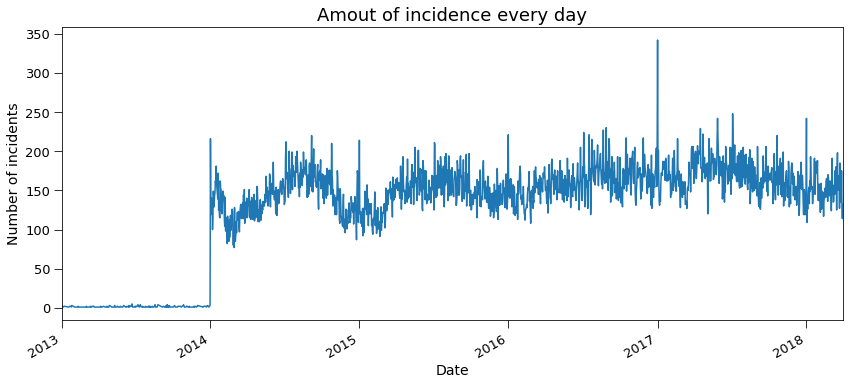

In [12]:
fig = plt.figure(figsize=(14, 6)) 
ax = fig.get_axes()

ax = df.groupby(by='date')['state'].count().plot()
ax.set_ylabel('Number of incidents', fontdict={'fontsize': 14})
ax.set_xlabel('Date', fontdict={'fontsize': 14})
ax.tick_params(labelsize=13, length=8)
ax.set_title('Amout of incidence every day', size=18);

### 2013 is almost empty year and it should be ignored.

In [13]:
df.drop(df.loc[df['year'] == 2013].index, axis=0, inplace=True)

In [14]:
df['year'].value_counts()

2017    61401
2016    58763
2015    53579
2014    51854
2018    13802
Name: year, dtype: int64

In [15]:
temp = df.loc[df['year'].between(2014, 2017), 'year'].value_counts()
np.polyfit(temp.index, temp.values, deg=1)

array([ 3.3825000e+03, -6.7610295e+06])

### It seems what amount of cases with guns increasing about 3400 incidents each year (if we drop 2018 because we don't have full data on them)

In [16]:
num_year = pd.DataFrame(columns=['type', 2014, 2015, 2016, 2017, 'coef'])
name = ['overall', 'no victims', 'victims']
for i, temp in enumerate([df.loc[df['year'] < 2018, 'year'].value_counts(), 
                       df.loc[(df['year'] < 2018) & (df['n_killed'] == 0) & (df['n_injured']  == 0), 
                              'date'].dt.year.value_counts(),
                       df.loc[(df['year'] < 2018) & ~((df['n_killed'] == 0) & (df['n_injured']  == 0)), 
                              'date'].dt.year.value_counts()]):
    d = {'type': name[i]}
    coef = np.polyfit(temp.index, temp.values, deg=1)[0]
    d.update(temp)
    d.update({'coef': coef})

    num_year = num_year.append(d, ignore_index=True)

num_year

,type,2014,2015,2016,2017,coef
0,overall,51854,53579,58763,61401,3382.5
1,no victims,23700,21121,22224,24272,281.9
2,victims,28154,32458,36539,37129,3100.6


### Number of incidents with no injured or killed people almost constant. Out of 3400 new incidents, 3100 are with injured or killed people.

In [17]:
for year in range(2014, 2018):
    print('In {} {} unique websites were used'\
          .format(year, df.loc[df['year'] == year, 'source_url']\
                  .str.split('//').str.get(1).str.replace('^www.','').str.split('/').str.get(0).nunique()))

In 2014 2001 unique websites were used
In 2015 1900 unique websites were used
In 2016 2197 unique websites were used
In 2017 2429 unique websites were used


In [18]:
for year in range(2014, 2018):
    print('In {} {} websites with more than 1 incident are used'\
          .format(year, (df.loc[df['year'] == year, 'source_url'].str.split('//')\
                  .str.get(1).str.replace('www.','').str.split('/').str.get(0)\
                  .value_counts() > 1).sum()))

In 2014 1310 websites with more than 1 incident are used
In 2015 1256 websites with more than 1 incident are used
In 2016 1515 websites with more than 1 incident are used
In 2017 1715 websites with more than 1 incident are used


### The amount of website where data is found is also increasing with time. 

In [19]:
amount = np.array([51854, 53579, 58763, 61401])
year = np.array([2001, 1900, 2197, 2429])
stats.pearsonr(amount, year)

(0.9286527706898371, 0.07134722931016291)

In [20]:
amount = np.array([51854, 53579, 58763, 61401])
year = np.array([1310, 1256, 1515, 1715])
stats.pearsonr(amount, year)

(0.9534795845489521, 0.0465204154510479)

### In both cases they highly correlated. But it doesn't mean that increasing of gun involved incidents can be explained by increasing of data sources.

# Work on participant features

In [21]:
for i in range(6):
    print('Part of incident with at least {1} person involved is {0}'\
          .format(round(df['participant_age'].str.split('\|+').str.get(i).str.replace('[\d]*:+', '')\
                        .notna().sum() / df['participant_age'].notna().sum(), 2), i+1))

Part of incident with at least 1 person involved is 1.0
Part of incident with at least 2 person involved is 0.34
Part of incident with at least 3 person involved is 0.1
Part of incident with at least 4 person involved is 0.03
Part of incident with at least 5 person involved is 0.01
Part of incident with at least 6 person involved is 0.0


In [22]:
# n_people is amount of people we try to extract from participant's features
# n_people <= 5 is 97% of dataset
n_people = 5
for person_number in range(n_people):
    df['age_{}'.format(person_number)] = df['participant_age'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')
    df['gender_{}'.format(person_number)] = df['participant_gender'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')

In [23]:
df['age_0'].dropna().astype('int').max(), df['age_0'].dropna().astype('int').min()

(311, 0)

In [24]:
# put restriction on age: 0 <= age <= 100
for person_number in range(n_people):
    df.loc[df['age_{}'.format(person_number)].astype('float') >= 100, 'age_{}'.format(person_number)] = 100
    df.loc[df['age_{}'.format(person_number)].astype('float') <= 0, 'age_{}'.format(person_number)] = 0

In [25]:
df['gender_0'].dropna().value_counts()

Male            177745
Female           25308
Male, female         1
Name: gender_0, dtype: int64

In [26]:
# put restriction on gender: gender is Male or Female
for person_number in range(n_people):
    df.loc[~df['gender_{}'.format(person_number)]\
           .isin(['Male', 'Female', np.NAN]), 'gender_{}'.format(person_number)] = 'Male'

In [27]:
list_noncense = ['Killed, Arrested', 'Injured, Unharmed', 'Injured, Unharmed, Arrested', 'Killed, Unharmed',
                 'Killed, Injured', 'Killed, Unharmed, Arrested']

for person_number in range(n_people):
    df['type_{}'.format(person_number)] = df['participant_type'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')
    df['status_{}'.format(person_number)] = df['participant_status'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')
    
for person_number in range(n_people):
    df.drop(df.loc[df['status_{}'.format(person_number)].isin(list_noncense)].index, axis=0, inplace=True)

In [28]:
# Some of category of incidents
description = ['Home Invasion', 'Armed robbery', 'Domestic Violence', 'Officer', 'Road rage', 'Sex crime', 
               'TSA Action', 'Car-jacking', 'Animal', 'Accidental', 'Drive-by', 'Drug involvement']

total = df['incident_characteristics'].notna().sum()
informative = df['incident_characteristics'].str.contains('|'.join(description)).sum()

Markdown("""
### There are {} description of incidents and only {} of them is useful. \
Others are something like 'Shot - Wounded/Injured' and not very informative.
""".format(total, informative))


### There are 238931 description of incidents and only 98774 of them is useful. Others are something like 'Shot - Wounded/Injured' and not very informative.


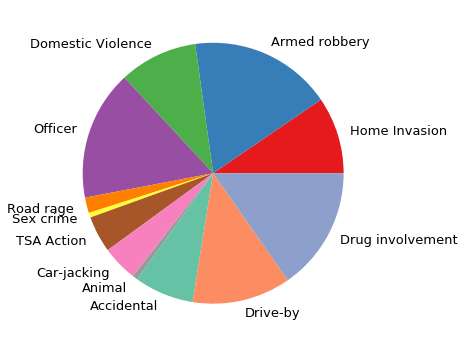

In [29]:
value = []
for desc in description:
    value.append(df['incident_characteristics'].str.contains(desc).sum())
    
plt.figure(figsize=(6, 6))
col = plt.cm.Set1.colors + plt.cm.Set2.colors
patches, texts = plt.pie(value, labels=description, colors=col[:len(value)])
[text.set_fontsize(13) for text in texts];

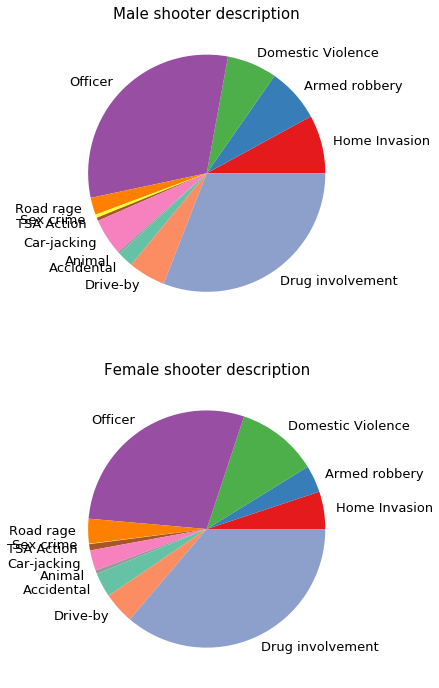

In [30]:
temp = pd.DataFrame()
for i in range(n_people):
    if temp.shape[0] > 0:
        temp.append(df.loc[(df['type_%s' % i] == 'Subject-Suspect'), 
                           ['gender_%s' % i, 'incident_characteristics']]\
                    .rename(columns={'gender_%s' % i: 'gender'}))
    else:
        temp = df.loc[(df['type_%s' % i] == 'Subject-Suspect'), 
                      ['gender_%s' % i, 'incident_characteristics']]\
        .rename(columns={'gender_%s' % i: 'gender'})
        
temp = temp.dropna()

fig, ax = plt.subplots(2, 1)
fig.set_figheight(2 * 6)
fig.set_figwidth(6)
col = plt.cm.Set1.colors + plt.cm.Set2.colors

for num, gender in enumerate(['Male', 'Female']):
    temp2 = temp.loc[(temp['gender'] == gender)]
    value = []
    for desc in description:
        value.append(temp2['incident_characteristics'].str.contains(desc).sum())

    patches, texts = ax[num].pie(x=value, labels=description, colors=col[:len(value)], startangle=0)
    ax[num].set_title('%s shooter description' % (gender), fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];

### Description of incidents where the shooter is known is different. The part of "Officer" and "Drug involved" incidents is much higher. It is expected that police incidents are better described.

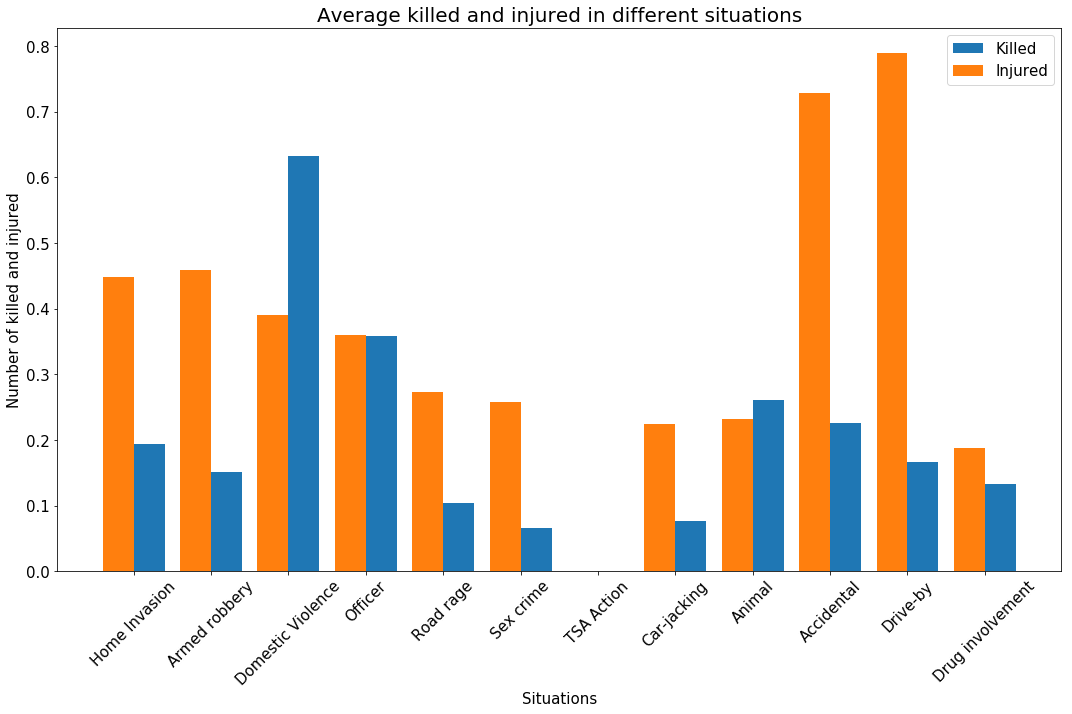

In [31]:
value_k = []
value_i = []

for desc in description:
    value_k.append(df.loc[df['incident_characteristics'].str.contains(desc) == True, 'n_killed'].mean())
    value_i.append(df.loc[df['incident_characteristics'].str.contains(desc) == True, 'n_injured'].mean())

plt.figure(figsize=(18, 10))
plt.bar(np.arange(len(description)) + 0.2, value_k, width=0.4, label='Killed', tick_label=description)
plt.bar(np.arange(len(description)) - 0.2, value_i, width=0.4, label='Injured')

plt.legend(fontsize=15)
plt.title('Average killed and injured in different situations', fontdict={'fontsize' : 20})
plt.xticks(np.arange(len(description)), rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Situations', fontsize=15)
plt.ylabel('Number of killed and injured', fontsize=15);

### The most dangerous situation are domestic violence and with involving police officer. TSA is Transportation Security Administration and mostly works in airports. This is explain why they almost doesn't have killed or injured person in their incidents.

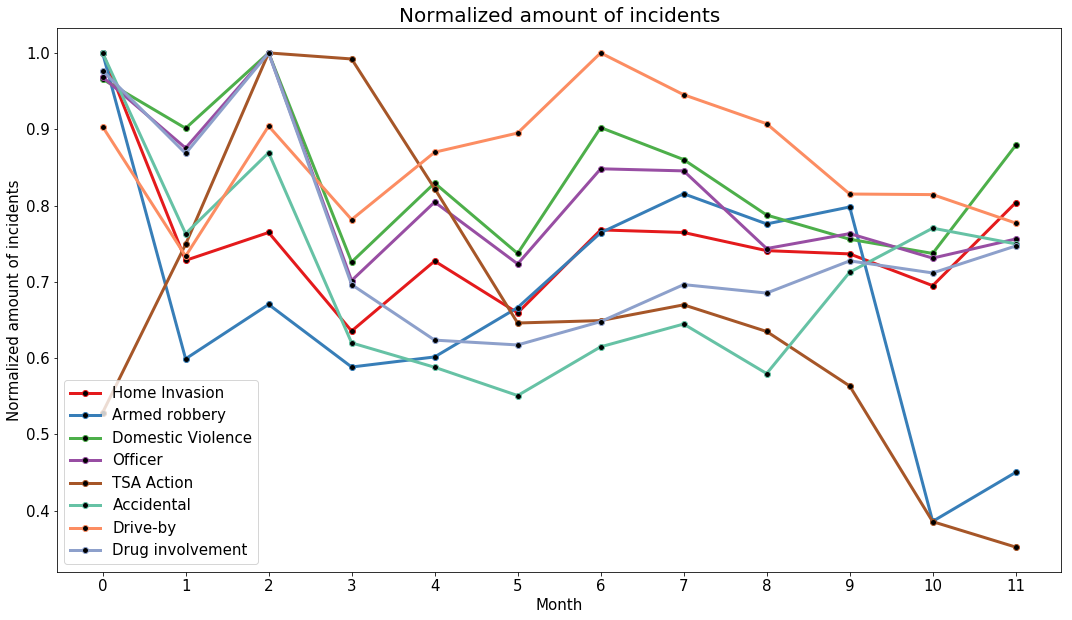

In [32]:
value_m = []
for desc in description:
    temp = df.loc[df['incident_characteristics'].str.contains(desc) == True, :]\
    .groupby(by='month')['date'].count()
    value_m.append(temp / temp.max())

fig = plt.figure(figsize=(18, 10))

skip_list = ['Animal', 'Sex crime', 'Road rage', 'Car-jacking']
for i, desc in enumerate(description):
    if desc in skip_list:
        continue
    plt.plot(range(value_m[i].shape[0]), value_m[i].values, label=desc, 
             c=col[i], linewidth=3, marker='o', markerfacecolor='k')
    
plt.legend(fontsize=15)
plt.title('Normalized amount of incidents', fontdict={'fontsize' : 20})
plt.xticks(np.arange(12), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Normalized amount of incidents', fontsize=15);

### There isn't clear dependence. Almost all of them have maximum in January.

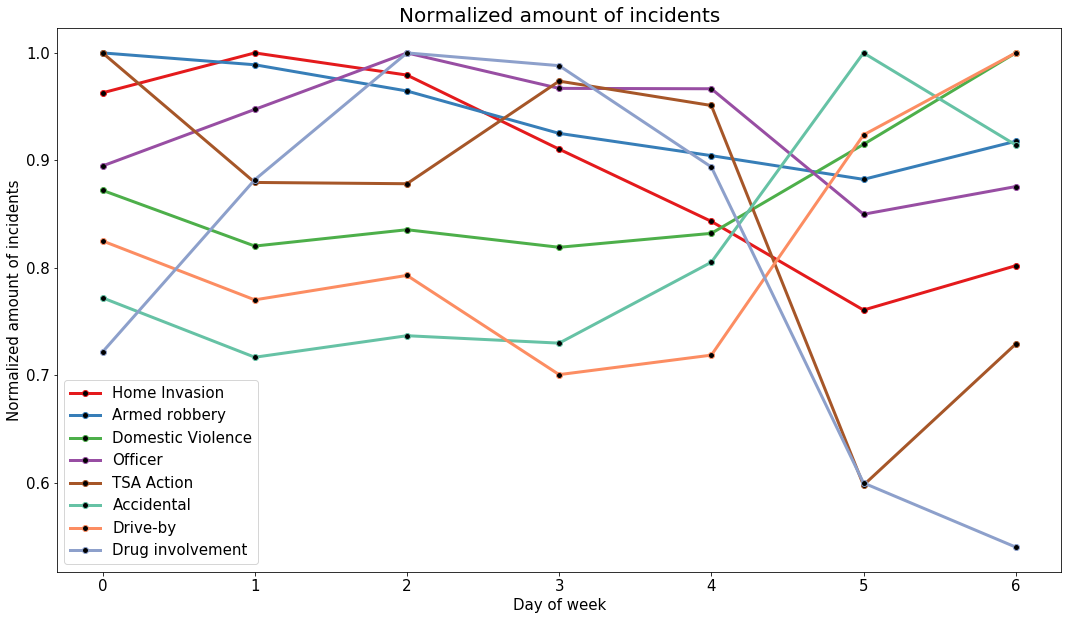

In [33]:
value_w = []
for desc in description:
    temp = df.loc[df['incident_characteristics'].str.contains(desc) == True, :]\
    .groupby(by='weekday')['date'].count()
    value_w.append(temp / temp.max())

fig = plt.figure(figsize=(18, 10))

skip_list = ['Animal', 'Sex crime', 'Road rage', 'Car-jacking']
for i, desc in enumerate(description):
    if desc in skip_list:
        continue
    plt.plot(range(value_w[i].shape[0]), value_w[i].values, label=desc, 
             c=col[i], linewidth=3, marker='o', markerfacecolor='k')
    
plt.legend(fontsize=15)
plt.title('Normalized amount of incidents', fontdict={'fontsize' : 20})
plt.xticks(np.arange(7), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Day of week', fontsize=15)
plt.ylabel('Normalized amount of incidents', fontsize=15);

### There are some reasonable on distribution over day of week. Domestic violence happen more often on weekends when everybody home together full day long. Home invasions happen less on weekends when owners are expected.

# Work on gun_type and n_guns_involved features

In [34]:
(df['n_guns_involved'].value_counts() / df['n_guns_involved'].value_counts().sum()).head(3).sum()

0.9773100601351256

### Incidents with 3 or less gun involved are about 97% (not including NAN) of our dataset, so it is ok to extract information of this amount of gun from feature gun_type 

In [35]:
df.gun_type.isnull().sum()

99239

In [36]:
n_gun = 3
for gun in range(n_gun):
    df['gun_type_{}'.format(gun)] = df['gun_type'].str.split('\|*')\
    .str.get(gun).str.replace('[\d*]:+', '')

/usr/local/lib/python3.5/dist-packages/pandas/core/strings.py:1328: FutureWarning:

split() requires a non-empty pattern match.



In [37]:
def freq_dict(df, feature_name='gun_type', n=n_gun):
    temp_dict = {}
    for gun in range(n):
        _ = df[feature_name + '_{}'.format(gun)].value_counts().to_dict()
        if len(temp_dict) == 0:
            temp_dict = _
        else:
            for (k, v) in _.items():
                if k in temp_dict:
                    temp_dict[k] += _[k]
                else:
                    temp_dict[k] = _[k] 
    return temp_dict

temp_dict = freq_dict(df)

In [38]:
temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp

,freq
Unknown,105007
Handgun,20948
9mm,6174
Rifle,3594
Shotgun,3547
22 LR,3133
40 SW,2613
380 Auto,2316
45 Auto,2239
38 Spl,1748


### There isn't information about gun type in most of incident, but we will analysis what we have.

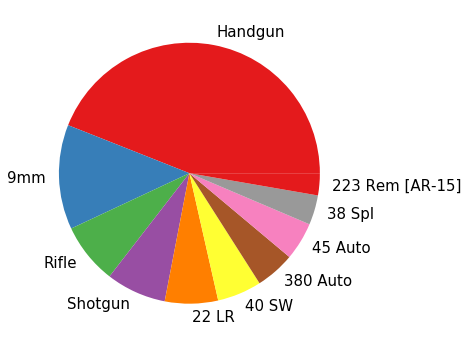

In [39]:
temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp = temp.reset_index().head(11)
temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
plt.figure(figsize=(6, 6))
patches, texts = plt.pie(x=temp['freq'], labels=temp['index'], colors=plt.cm.Set1.colors[:temp['index'].shape[0]])

[text.set_fontsize(15) for text in texts];

### The most incidents happened with handgun.

In [40]:
amount_of_killed = 4
temp_list_with_dict_k = [freq_dict(df.loc[df['n_killed'] == i]) for i in range(amount_of_killed)] \
+ [freq_dict(df.loc[df['n_killed'] >= amount_of_killed])]

temp_list_with_str_k = ['With {} dead | {} incidents'\
                      .format(i, df.loc[df['n_killed'] == i].shape[0]) for i in range(amount_of_killed)]\
+ ['With >= {} dead | {} incidents'\
   .format(amount_of_killed, df.loc[df['n_killed'] == amount_of_killed].shape[0])] 


amount_of_injured = 4
temp_list_with_dict_i = [freq_dict(df.loc[df['n_injured'] == i]) for i in range(amount_of_injured)] \
+ [freq_dict(df.loc[df['n_injured'] >= amount_of_injured])]

temp_list_with_str_i = ['With {} injured | {} incidents'\
                      .format(i, df.loc[df['n_injured'] == i].shape[0]) for i in range(amount_of_injured)]\
+ ['With >= {} injured | {} incidents'\
   .format(amount_of_injured, df.loc[df['n_injured'] == amount_of_injured].shape[0])] 

n_casulties = 4
temp_list_with_dict_c = [freq_dict(df.loc[df['n_victim'] == i]) for i in range(n_casulties)] \
+ [freq_dict(df.loc[df['n_victim'] >= n_casulties])]

temp_list_with_str_c = ['With {} killed or injured | {} incidents'\
                      .format(i, df.loc[df['n_victim'] == i].shape[0]) for i in range(n_casulties)]\
+ ['With >= {} killed or injured | {} incidents'\
   .format(n_casulties, df.loc[df['n_victim'] == n_casulties].shape[0])] 

In [41]:
# map wepon to color
temp_dict = freq_dict(df)
temp_color = pd.DataFrame.from_dict(temp_dict, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp_color = temp_color.reset_index().head(21)
temp_color.drop(temp_color.loc[(temp_color['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, 
                axis=0, inplace=True)
temp_color['color'] = (plt.cm.Set1.colors + plt.cm.Dark2.colors + plt.cm.tab10.colors)\
[:temp_color['index'].shape[0]]
temp_color.drop(['freq'], axis=1, inplace=True)

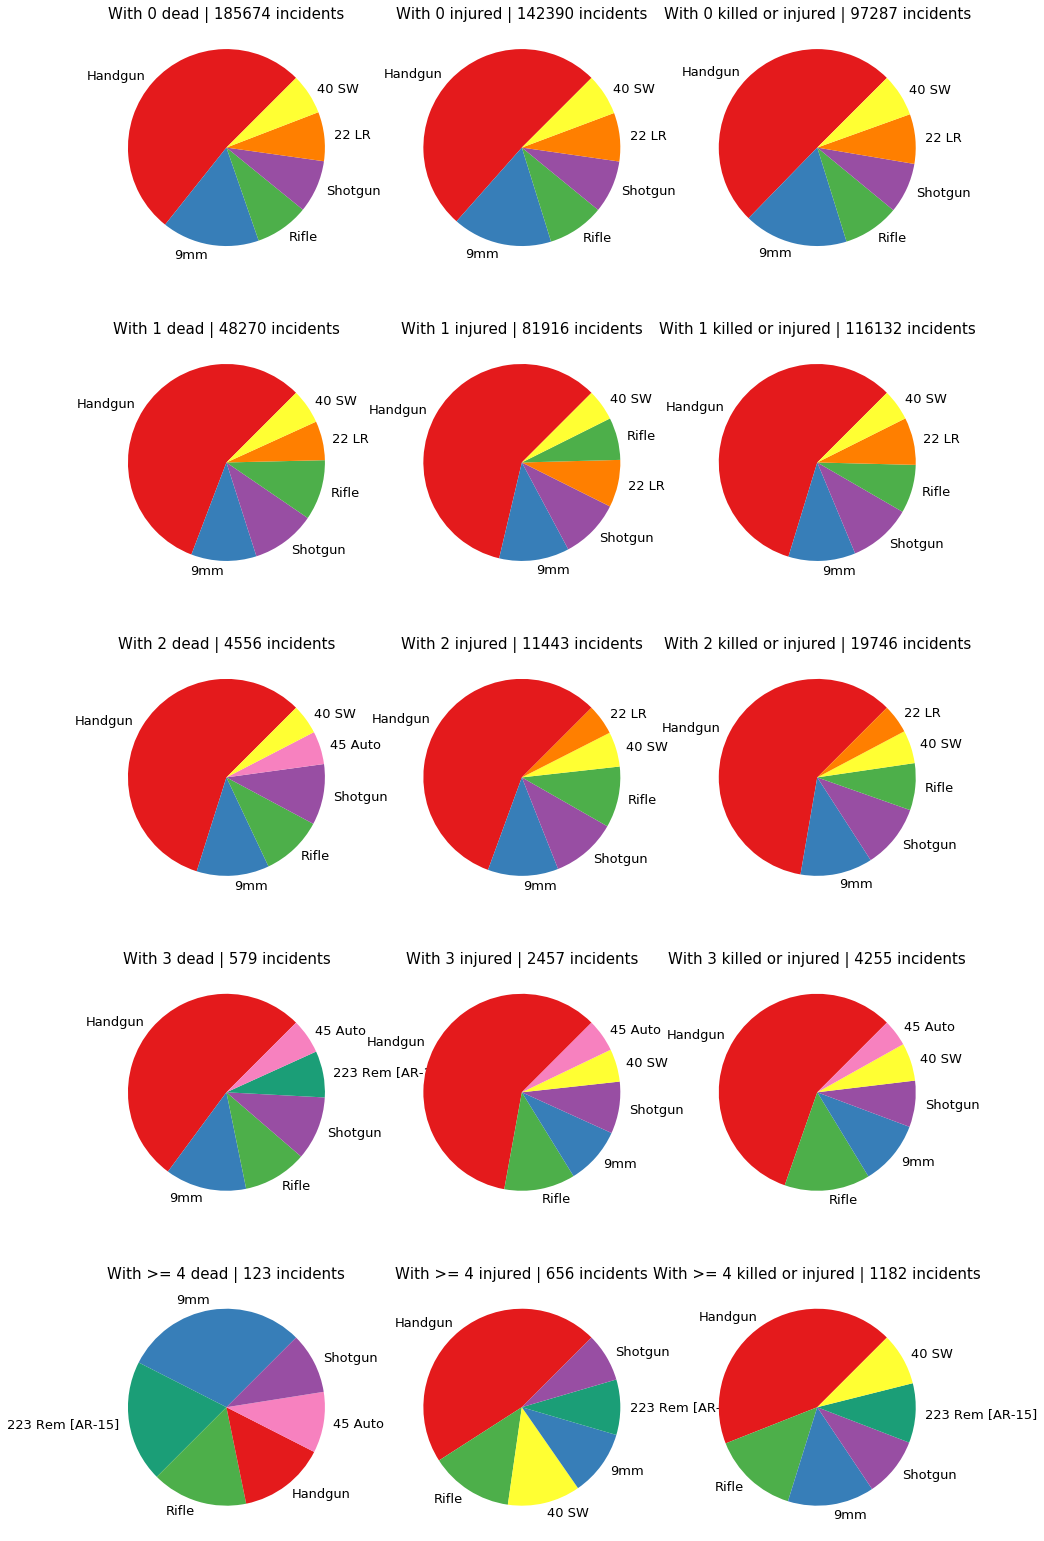

In [42]:
fig, ax = plt.subplots(len(temp_list_with_dict_k), 3)
fig.set_figheight(7 * amount_of_killed)
fig.set_figwidth(15)

for i, temp_dict in enumerate(temp_list_with_dict_k):
    temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
    .rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)

    temp = temp.reset_index().head(7)
    temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
    temp = temp.merge(temp_color, how='inner', on='index')
    patches, texts = ax[i, 0].pie(x=temp['freq'], labels=temp['index'], colors=temp['color'], startangle=45)
    ax[i, 0].set_title(temp_list_with_str_k[i], fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];
    
for i, temp_dict in enumerate(temp_list_with_dict_i):
    temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
    .rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)

    temp = temp.reset_index().head(7)
    temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
    temp = temp.merge(temp_color, how='inner', on='index')
    patches, texts = ax[i, 1].pie(x=temp['freq'], labels=temp['index'], colors=temp['color'], startangle=45)
    ax[i, 1].set_title(temp_list_with_str_i[i], fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];
    
for i, temp_dict in enumerate(temp_list_with_dict_c):
    temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
    .rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)

    temp = temp.reset_index().head(7)
    temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
    temp = temp.merge(temp_color, how='inner', on='index')
    patches, texts = ax[i, 2].pie(x=temp['freq'], labels=temp['index'], colors=temp['color'], startangle=45)
    ax[i, 2].set_title(temp_list_with_str_c[i], fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];

### In mass shooting part of handguns is decreasing.

In [43]:
# There are much more male than female
freq_dict(df, 'gender', 5)

{'Female': 42305, 'Male': 304648}

In [44]:
# ratio
304734 / 42234

7.215371501633755

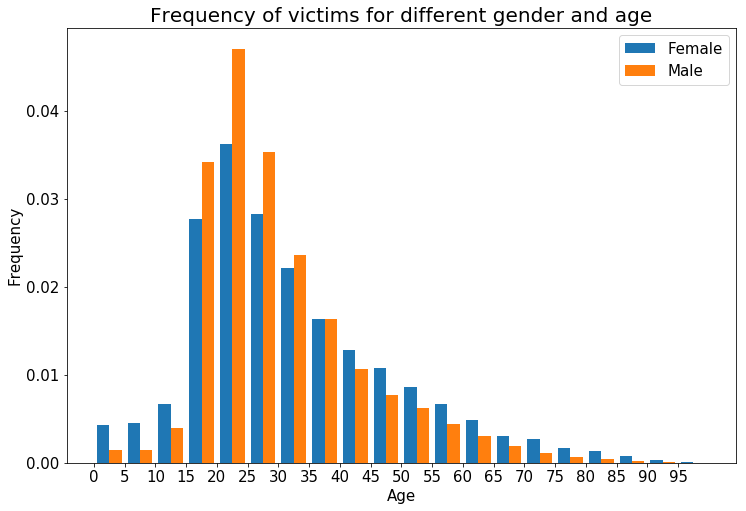

In [45]:
fig = plt.figure(figsize=(12, 8))
temp = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Victim'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Victim'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
plt.hist([temp, temp2], bins=20, density=True, label=['Female', 'Male']);
plt.legend(fontsize=15)
plt.title('Frequency of victims for different gender and age', fontdict={'fontsize' : 20})
plt.xticks(np.arange(0, 100, step=5), fontsize=15);
plt.xlabel('Age', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=15);

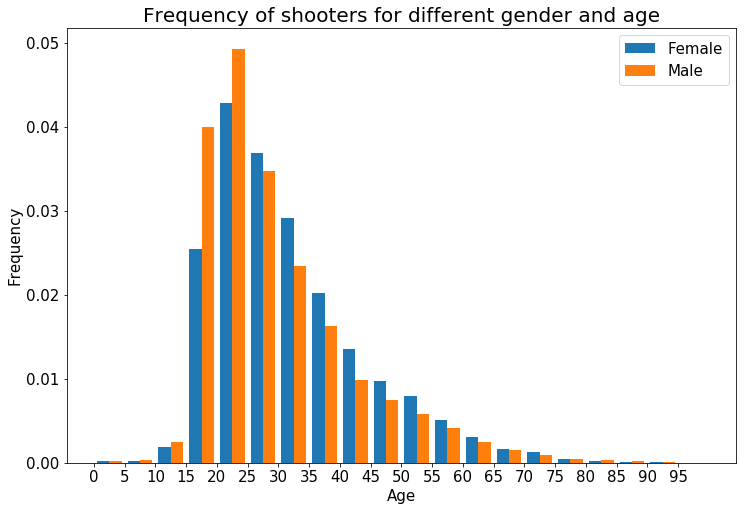

In [46]:
fig = plt.figure(figsize=(12, 8))
temp = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
plt.hist([temp, temp2], bins=20, density=True, label=['Female', 'Male']);
plt.legend(fontsize=15)
plt.title('Frequency of shooters for different gender and age', fontdict={'fontsize' : 20})
plt.xticks(np.arange(0, 100, step=5), fontsize=15);
plt.xlabel('Age', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=15);

### There isn't any different between victims and shooters in age distribution. Also their mean age is almost the same and isn't depend on gender or role in incident.

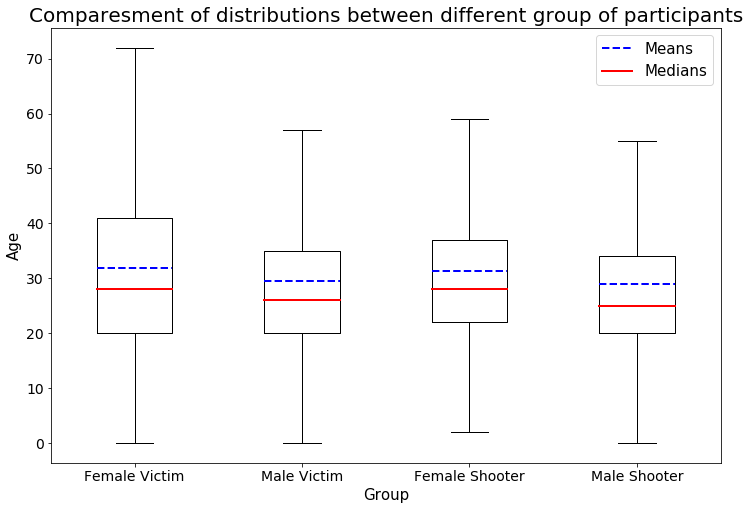

In [47]:
temp1 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Victim'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Victim'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp3 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp4 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])

fig = plt.figure(figsize=(12, 8))
plt.title('Comparesment of distributions between different group of participants', fontsize=20)
lines = plt.boxplot([temp1, temp2, temp3, temp4], 
            labels=['Female Victim', 'Male Victim', 'Female Shooter', 'Male Shooter'], showfliers=False,
            showmeans=True, meanline=True)

[i.set_linewidth(2) for i in lines['means']]
[i.set_color('blue') for i in lines['means']]
[i.set_linewidth(2) for i in lines['medians']]
[i.set_color('red') for i in lines['medians']]

plt.legend((lines['means'][0], lines['medians'][0]), ['Means', 'Medians'], fontsize=15)
plt.ylabel('Age', fontsize=15)
plt.xlabel('Group', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
del temp1, temp2, temp3, temp4

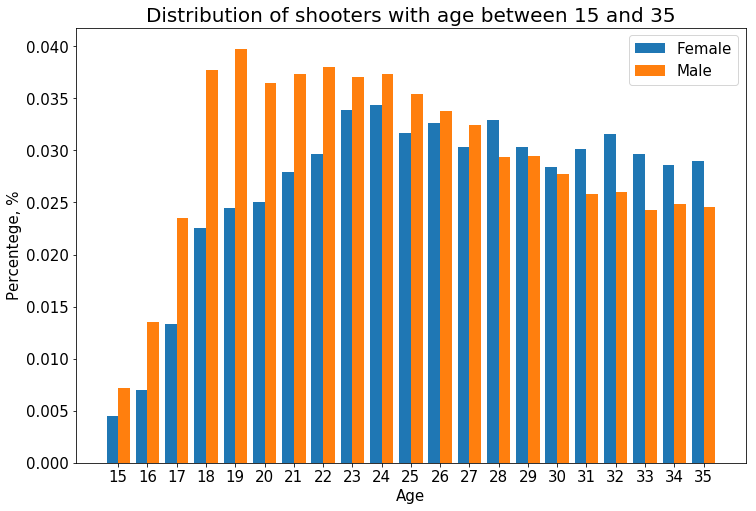

In [48]:
# more precise analysis about young people

start_age = 15
end_age = 35
fig = plt.figure(figsize=(12, 8))
temp = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
# temp = temp[(temp >= start_age) & (temp <= end_age)]
# temp2 = temp2[(temp2 >= start_age) & (temp2 <= end_age)]

plt.bar(np.arange(start_age, end_age + 1) - 0.2, [temp[temp == i].sum() / temp.sum() 
                                  for i in range(start_age, end_age+1)], width=0.4, label='Female')
plt.bar(np.arange(start_age, end_age + 1) + 0.2, [temp2[temp2 == i].sum() / temp2.sum() 
                                  for i in range(start_age, end_age+1)], width=0.4, label='Male')
plt.legend(fontsize=15)
plt.title('Distribution of shooters with age between %s and %s' % (start_age, end_age), fontdict={'fontsize' : 20})
plt.xticks(np.arange(start_age, end_age + 1), fontsize=15);
plt.xlabel('Age', fontsize=15)
plt.ylabel('Percentege, %', fontsize=15)
plt.yticks(fontsize=15);

### From graph it's clear that distributions for male and female are different. Peak of incidents with male shooter at 19 years old and then declining. Peak of incidents with female shooter at 23 years old and then very slowly declining. It's almost uniformal distribution till 35 years old.

In [49]:
df['status_0'].value_counts()

Injured               85770
Killed                50651
Unharmed, Arrested    35174
Unharmed              34428
Arrested               3819
Injured, Arrested      1789
Name: status_0, dtype: int64

In [50]:
status_k = ['Killed']
status_i = ['Injured', 'Injured, Arrested']
status_u = ['Unharmed, Arrested', 'Unharmed', 'Arrested']

In [51]:
def frequency_incidents(df, gender, rolle, status_group, n_people=n_people):
    return sum([df.loc[(df['gender_%s' % i] == gender) & (df['type_%s' % i] == rolle) & \
                         (df['status_%s' % i].isin(status_group)), 'n_victim'].shape[0] \
                for i in range(n_people)])

In [52]:
temp_f_k_v = frequency_incidents(df, 'Female', 'Victim', status_k)
temp_m_k_v = frequency_incidents(df, 'Male', 'Victim', status_k)
temp_f_i_v = frequency_incidents(df, 'Female', 'Victim', status_i)
temp_m_i_v = frequency_incidents(df, 'Male', 'Victim', status_i)
temp_f_u_v = frequency_incidents(df, 'Female', 'Victim', status_u)
temp_m_u_v = frequency_incidents(df, 'Male', 'Victim', status_u)

temp_f_k_s = frequency_incidents(df, 'Female', 'Subject-Suspect', status_k)
temp_m_k_s = frequency_incidents(df, 'Male', 'Subject-Suspect', status_k)
temp_f_i_s = frequency_incidents(df, 'Female', 'Subject-Suspect', status_i)
temp_m_i_s = frequency_incidents(df, 'Male', 'Subject-Suspect', status_i)
temp_f_u_s = frequency_incidents(df, 'Female', 'Subject-Suspect', status_u)
temp_m_u_s = frequency_incidents(df, 'Male', 'Subject-Suspect', status_u)

f_max_v = sum([temp_f_k_v, temp_f_i_v, temp_f_u_v])
f_max_s = sum([temp_f_k_s, temp_f_i_s, temp_f_u_s])
m_max_v = sum([temp_m_k_v, temp_m_i_v, temp_m_u_v])
m_max_s = sum([temp_m_k_s, temp_m_i_s, temp_m_u_s])

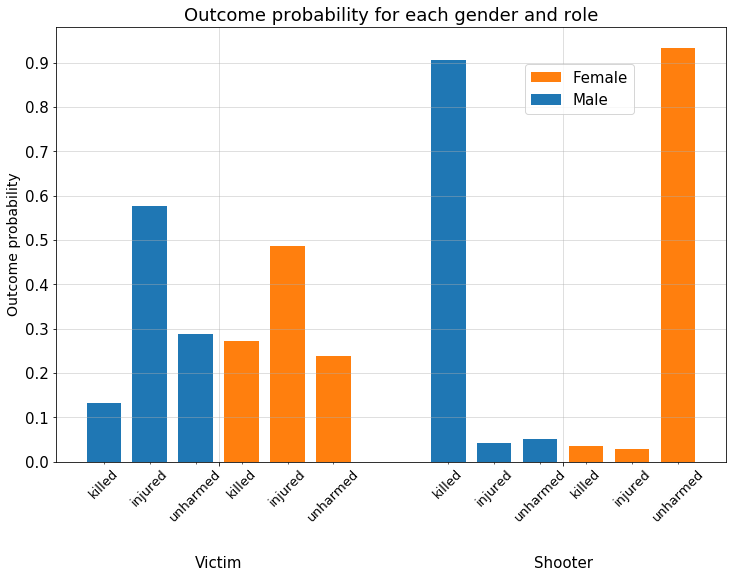

In [53]:
blue = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
orange = (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)

fig = plt.figure(figsize=(12, 8))
plt.bar(np.arange(0, 6, 3) + 0.2, [temp_f_k_v / f_max_v, temp_f_k_s / f_max_s], width=0.3, label='Female', 
        color=orange)
plt.bar(np.arange(0, 6, 3) + 0.6, [temp_f_i_v / f_max_v, temp_f_i_s / f_max_s], width=0.3, color=orange)
plt.bar(np.arange(0, 6, 3) + 1, [temp_f_u_v / f_max_v, temp_f_u_s / f_max_s], width=0.3, color=orange)

plt.bar(np.arange(0, 6, 3) - 0.2, [temp_m_k_v / m_max_v, temp_m_k_s / m_max_s], width=0.3, label='Male', 
        color=blue)
plt.bar(np.arange(0, 6, 3) - 0.6, [temp_m_i_v / m_max_v, temp_m_i_s / m_max_s], width=0.3, color=blue)
plt.bar(np.arange(0, 6, 3) - 1, [temp_m_u_v / m_max_v, temp_m_u_s / m_max_s], width=0.3, color=blue)

plt.legend(fontsize=15, loc=(0.7, 0.8))
plt.title('Outcome probability for each gender and role', fontdict={'fontsize' : 18})
ax = fig.get_axes()[0]
ax.xaxis.set_minor_locator(ticker.FixedLocator(([-1, -0.6, -0.2, 0.2, 0.6, 1, 2, 2.4, 2.8, 3.2, 3.6, 4])))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter((['killed', 'injured', 'unharmed'] * 4)))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=45, fontsize=13)

ax.xaxis.set_major_locator(ticker.FixedLocator(([0, 3])))
ax.xaxis.set_major_formatter(ticker.FixedFormatter((['Victim', 'Shooter'])))
ax.xaxis.get_majorticklabels()[0].set_position((0, -0.2))
ax.xaxis.get_majorticklabels()[1].set_position((3, -0.2))
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=15)
plt.setp(ax.yaxis.get_majorticklabels(), fontsize=15)
ax.set_yticks(np.arange(0, 1, 0.1))
ax.grid(which='y')
ax.grid(which='major', alpha=0.5)
ax.set_ylabel('Outcome probability', fontsize=14);

### The distribution between gender is pretty different, especially in role of shooter. Female shooter has much more chances to be unharmed, while male shooter most likely to be killed.

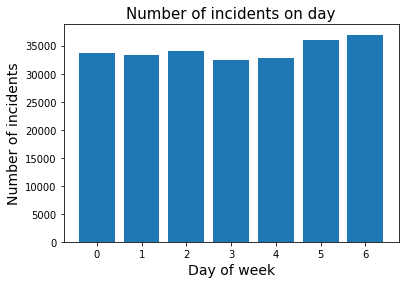

In [54]:
week = df['weekday'].value_counts().reset_index().rename(columns={'index': 'weekday', 'weekday': 'count'})
ax = plt.axes()
plt.bar(week['weekday'], week['count']);

ax.set_title('Number of incidents on day', fontdict={'fontsize': 15})
ax.set_xlabel('Day of week', fontsize=14)
ax.set_ylabel('Number of incidents', fontsize=14);

### There is a little bit more incidents on weekends. Let's use statistical test to know that this is not random noise.

In [55]:
temp = df.groupby(by=['year', 'weekofyear', 'weekday'])['date'].count()
temp = temp.reset_index().rename(columns={'date': 'count'})
day_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

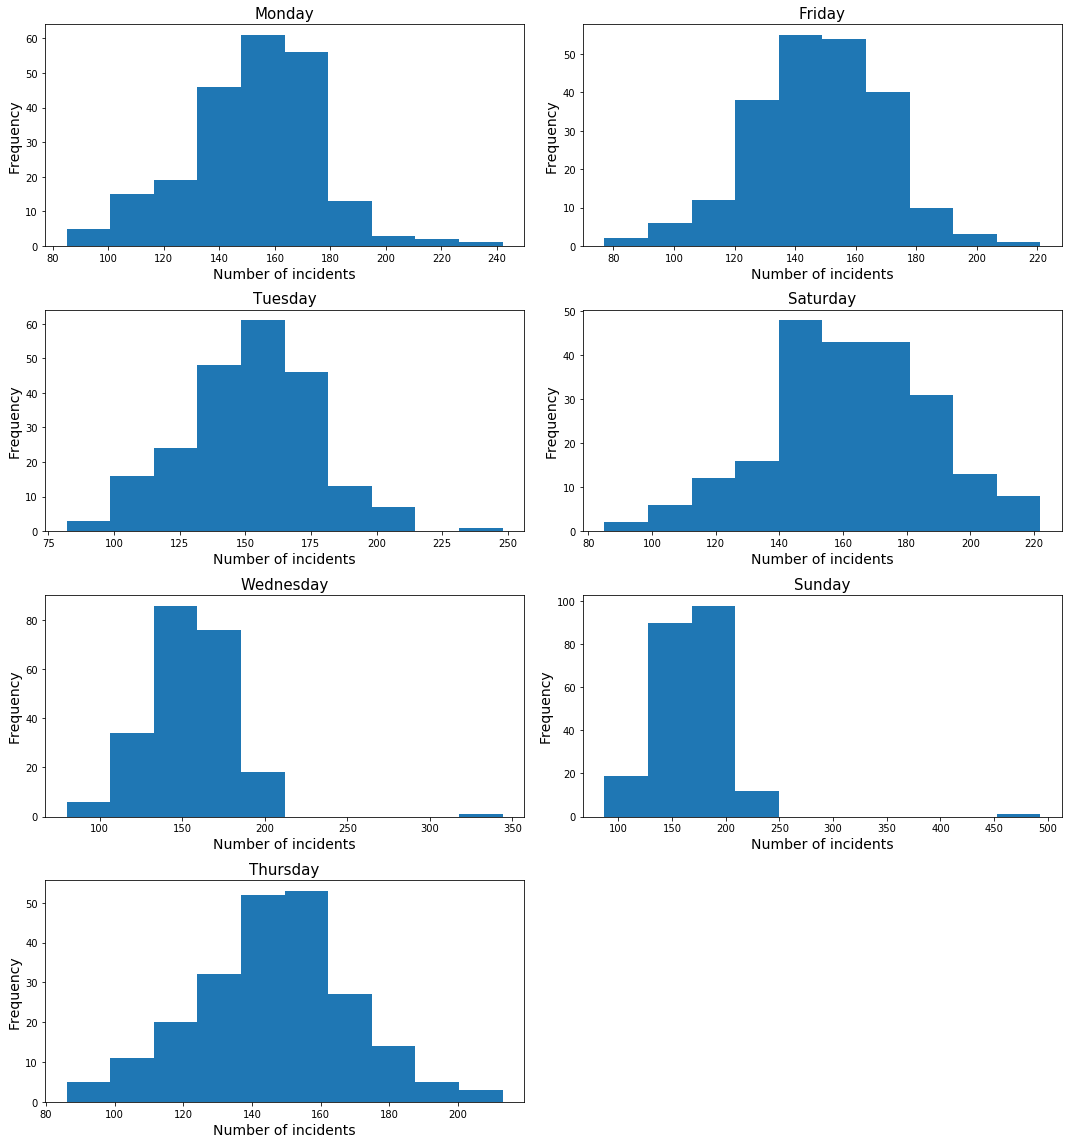

In [56]:
# Check for normality
fig, ax = plt.subplots(4, 2)
fig.set_figheight(4 * 4)
fig.set_figwidth(15)

for day in range(8):
    column = 0
    row = day
    if day >= 4:
        row-=4
        column = 1
        if day == 7:
            # hide graph
            ax[row, column].axes.get_xaxis().set_visible(False)
            ax[row, column].axes.get_yaxis().set_visible(False)
            plt.box(False)
            continue
    a = ax[row, column].hist(temp.loc[temp['weekday'] == day, 'count'])
    ax[row, column].set_title(day_list[day], fontdict={'fontsize': 15})
    ax[row, column].set_xlabel('Number of incidents', fontsize=14)
    ax[row, column].set_ylabel('Frequency', fontsize=14);
plt.tight_layout()

In [57]:
# Check that standard deviations of the groups are equal
for day in range(7):
    print('For day #{} mean is {} and std is {}'.format(day, temp.loc[temp['weekday'] == day, 'count'].mean(), 
                    temp.loc[temp['weekday'] == day, 'count'].std()))

For day #0 mean is 152.54298642533936 and std is 24.05342931787098
For day #1 mean is 151.8584474885845 and std is 24.508434409641094
For day #2 mean is 154.1945701357466 and std is 26.895304886318232
For day #3 mean is 146.46396396396398 and std is 22.4981861221305
For day #4 mean is 148.1266968325792 and std is 21.792664788523332
For day #5 mean is 162.2117117117117 and std is 25.643840567429354
For day #6 mean is 167.95 and std is 35.86736411027688


### Sample is not perfectly normal and std of sunday is pretty different. We will use Kruskal–Wallis test instead of ANOVA because is required only independence of data and more conservative.

In [58]:
stats.kruskal(temp.loc[temp['weekday'] == 0, 'count'], 
               temp.loc[temp['weekday'] == 1, 'count'],
               temp.loc[temp['weekday'] == 2, 'count'],
               temp.loc[temp['weekday'] == 3, 'count'],
               temp.loc[temp['weekday'] == 4, 'count'],
               temp.loc[temp['weekday'] == 5, 'count'],
               temp.loc[temp['weekday'] == 6, 'count'])

KruskalResult(statistic=101.40126172777717, pvalue=1.2797346322677868e-19)

### It appears that hypothesis of equal means is very unlikely. Let's use t-test to compare average amount of incident of Wednesday and Saturday. Wednesday has biggest average amount of incidents within weekday and Saturday has smallest average amount of incidents within weekend.

In [59]:
stats.ttest_ind(temp.loc[temp['weekday'] == 2, 'count'], temp.loc[temp['weekday'] == 5, 'count'])

Ttest_indResult(statistic=-3.210979856268291, pvalue=0.0014195792380124641)

### Hypothesis of equal means can be rejected on significant level 1%

In [60]:
def check_season(week):
    if week >= 15 and week < 27:
        return 'spring'
    if week >= 27 and week < 39:
        return 'summer'
    if week >= 39 and week < 51:
        return 'fall'
    else:
        return 'winter'
df['season'] = df['date'].dt.weekofyear.apply(check_season)

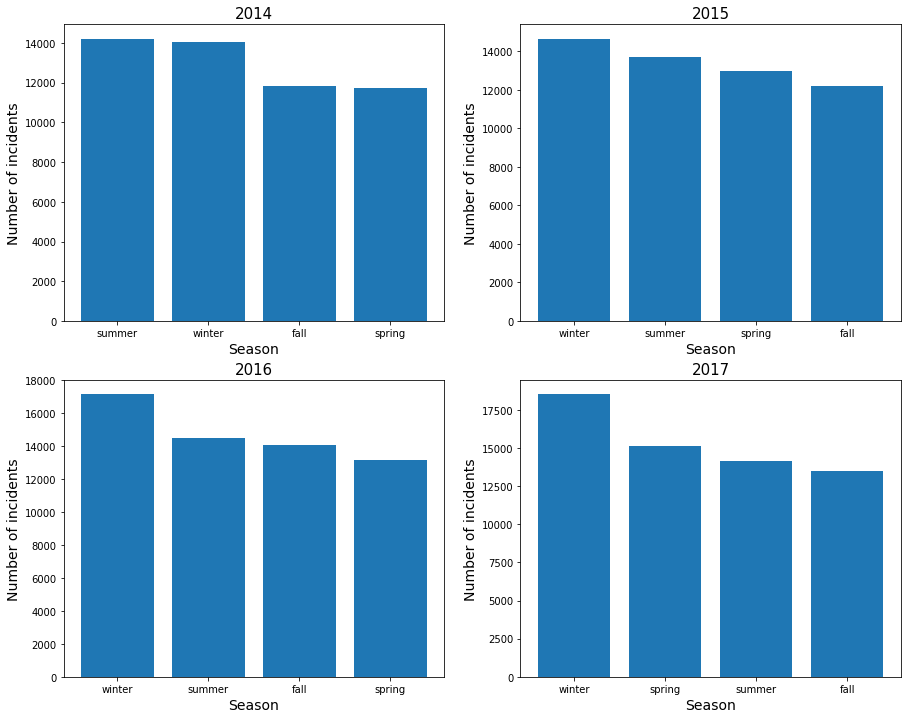

In [61]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(4 * 3)
fig.set_figwidth(15)

for i, year in enumerate([2014, 2015, 2016, 2017]):
    season = df.loc[df['year'] == year, 'season'].value_counts()\
    .reset_index().rename(columns={'index': 'season', 'season': 'n_incidents'})

    if i >= 2:
        ax[1, i % 2].set_title(year, fontdict={'fontsize': 15})
        ax[1, i % 2].set_xlabel('Season', fontsize=14)
        ax[1, i % 2].set_ylabel('Number of incidents', fontsize=14)
        ax[1, i % 2].bar(season['season'].values, season['n_incidents'].values);
    else:
        ax[0, i].set_title(year, fontdict={'fontsize': 15})
        ax[0, i].set_xlabel('Season', fontsize=14)
        ax[0, i].set_ylabel('Number of incidents', fontsize=14)
        ax[0, i].bar(season['season'].values, season['n_incidents'].values);

### The winter is a dominant in number of incidents. Summer is seemed to be violent season too, but it's not true about 2017. Let's consider smaller dateframe.

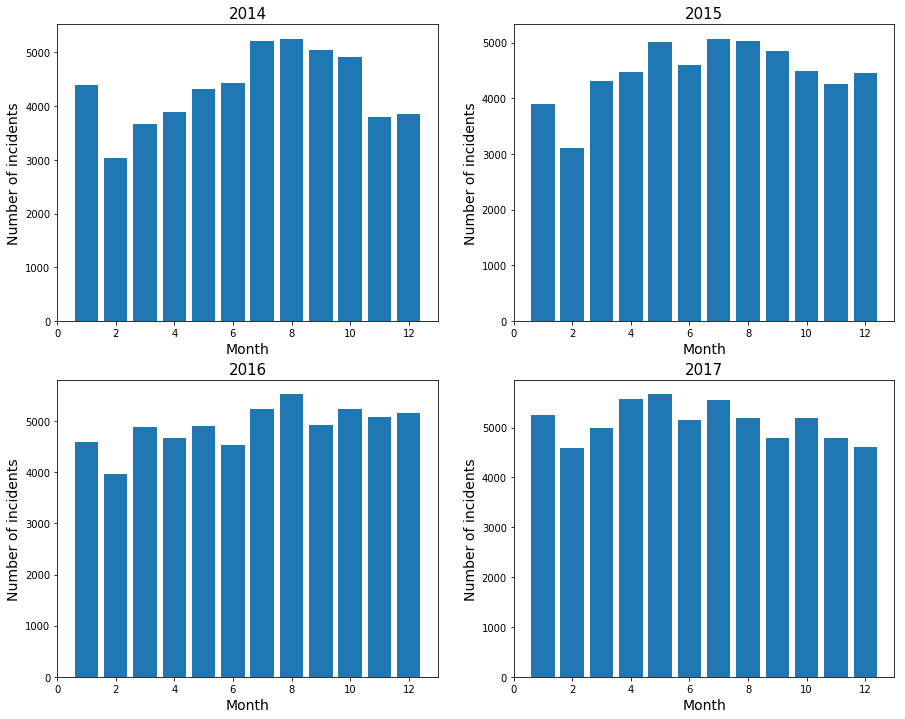

In [62]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(4 * 3)
fig.set_figwidth(15)

for i, year in enumerate([2014, 2015, 2016, 2017]):
    month = df.loc[df['year'] == year, 'month'].value_counts()\
    .reset_index().rename(columns={'index': 'month', 'month': 'count'})
    month = month.sort_values(by='month')
    if i >= 2:
        ax[1, i % 2].set_title(year, fontdict={'fontsize': 15})
        ax[1, i % 2].set_xlabel('Month', fontsize=14)
        ax[1, i % 2].set_ylabel('Number of incidents', fontsize=14)
        ax[1, i % 2].bar(month['month'], month['count'], label=year);
    else:
        ax[0, i].set_title(year, fontdict={'fontsize': 15})
        ax[0, i].set_xlabel('Month', fontsize=14)
        ax[0, i].set_ylabel('Number of incidents', fontsize=14)
        ax[0, i].bar(month['month'], month['count']);

### There isn't a clear dependence. It seems that there are more incidents during summer, but it's not true about 2017. January has bigger amount of incidents than February. It can be because of holidays. 

In [63]:
calendar = pd.DataFrame(data=pd.date_range(start='2013-12-29', end='2018-12-29', freq='d'), columns=['date'])

calendar['year'] = calendar['date'].dt.year
calendar['month'] = calendar['date'].dt.month
calendar['day'] = calendar['date'].dt.day
calendar['day_of_week'] = calendar['date'].dt.day_name()
calendar['nth_day'] = calendar[['year', 'month', 'day_of_week', 'date']]\
.groupby(['year', 'month', 'day_of_week']).rank()

holiday_names = ['New Years Day', 'Martin Luther King Jr. Day', 'President\'s Day', 'Memorial Day', 
                 'Independence Day', 'Labor Day', 'Colombus Day', 'Veterans Day', 'Thanksgiving', 'Christmas Day']

# New Years Day
holiday_NY = calendar.loc[(calendar['month'] == 1) & (calendar['day'] == 1), 'date'].tolist()

# Martin Luther King Jr. Day
holiday_MLK = calendar.loc[(calendar['month'] == 1) & (calendar['day_of_week'] == 'Monday') 
                           & (calendar['nth_day'] == 3), 'date'].tolist()

# President day
holiday_PD = calendar.loc[(calendar['month'] == 2) & (calendar['day_of_week'] == 'Monday') 
                          & (calendar['nth_day'] == 3), 'date'].tolist()

# Memorial Day
holiday_MD = calendar.loc[(calendar['month'] == 5) & (calendar['day_of_week'] == 'Monday'), 
             ['date', 'year']].groupby('year').last()['date'].tolist()

# Independence Day
holiday_ID = calendar.loc[(calendar['month'] == 7) & (calendar['day'] == 4), 'date'].tolist()

# Labor Day
holiday_LD = calendar.loc[(calendar['month'] == 9) & (calendar['day_of_week'] == 'Monday') 
                           & (calendar['nth_day'] == 1), 'date'].tolist()

# Colombus Day
holiday_CD = calendar.loc[(calendar['month'] == 10) & (calendar['day_of_week'] == 'Monday') 
                           & (calendar['nth_day'] == 2), 'date'].tolist()

# Veterans Day
holiday_VD = calendar.loc[(calendar['month'] == 11) & (calendar['day'] == 11), 'date'].tolist()

# Thanksgiving
holiday_TH = calendar.loc[(calendar['month'] == 11) & (calendar['day_of_week'] == 'Thursday') 
                           & (calendar['nth_day'] == 4), 'date'].tolist()

# Christmas Day
holiday_CHR = calendar.loc[(calendar['month'] == 12) & (calendar['day'] == 25), 'date'].tolist()

In [64]:
def holiday_vs_casual(df, stat):
    temp_diff = []

    for holiday in [holiday_NY, holiday_MLK, holiday_PD, holiday_MD, holiday_ID, 
                         holiday_LD, holiday_CD, holiday_VD, holiday_TH, holiday_CHR]:
        temp = []
        for day in holiday:
            dates_h = pd.date_range(pd.to_datetime(day) - pd.to_timedelta('1 days'), 
                                    pd.to_datetime(day) + pd.to_timedelta('1 days'), freq='D')

            dates = pd.date_range(pd.to_datetime(day) + pd.to_timedelta('2 days'), 
                                  pd.to_datetime(day) + pd.to_timedelta('4 days'), freq='D')\
            .append(pd.date_range(pd.to_datetime(day) - pd.to_timedelta('4 days'), 
                                  pd.to_datetime(day) - pd.to_timedelta('2 days'), freq='D'))
            
            if stat == 'count':
                temp.append((df.loc[df['date'].isin(dates_h), 'date'].value_counts().sum() / 3)\
                            - (df.loc[df['date'].isin(dates), 'date'].value_counts().sum() / 6))
            if stat == 'injured':
                temp.append((df.loc[df['date'].isin(dates_h), 'n_injured'].sum() / 3)\
                            - (df.loc[df['date'].isin(dates), 'n_injured'].sum() / 6))
            if stat == 'killed':
                temp.append((df.loc[df['date'].isin(dates_h), 'n_killed'].sum() / 3)\
                            - (df.loc[df['date'].isin(dates), 'n_killed'].sum() / 6))

        temp_diff.append(np.array(temp).mean(axis=0))
    return temp_diff

In [65]:
h_t = holiday_vs_casual(df, 'count')
h_k = holiday_vs_casual(df, 'killed')
h_i = holiday_vs_casual(df, 'injured')

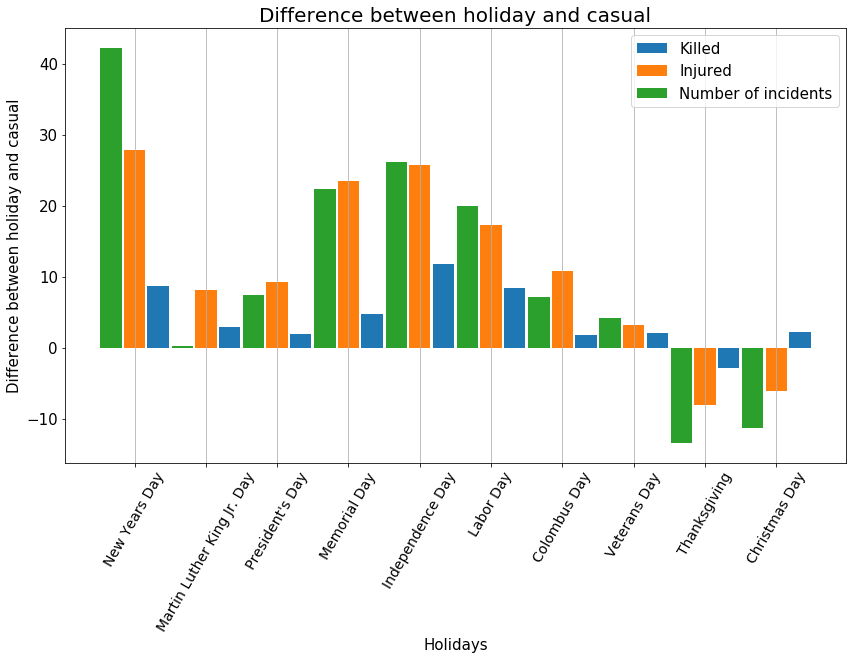

In [66]:
fig = plt.figure(figsize=(14, 8))
ax = plt.axes()
plt.bar(np.arange(len(h_k)) + 0.33, h_k, width=0.3, label='Killed')
plt.bar(np.arange(len(h_k)) - 0, h_i, width=0.3, label='Injured')
plt.bar(np.arange(len(h_k)) - 0.33, h_t, width=0.3, label='Number of incidents')
plt.legend(fontsize=15)
plt.title('Difference between holiday and casual', fontdict={'fontsize' : 20})

ax.xaxis.set_major_locator(ticker.FixedLocator((np.arange(len(h_k)))))
ax.xaxis.set_major_formatter(ticker.FixedFormatter((holiday_names)))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60, fontsize=14)
plt.yticks(fontsize=15)
plt.xlabel('Holidays', fontsize=15)
plt.ylabel('Difference between holiday and casual', fontsize=15);
ax.xaxis.grid()

### There are increment of gun violence on holidays. Let's consider amount of killed and injured. There are more of them on New Year, Memorial, Independence and Labor Days than on casual days. And reducing on Christmas and Thanksgiving.

In [67]:
# population for July 1 2016 
# Source: U.S. Census Bureau, Population Division
state_pop = pd.read_excel('nst-est2016-01.xlsx', skiprows=3, usecols=[0, 9])\
.rename(columns={2016: 'population', 'Unnamed: 0': 'state'})
state_pop['state'] = state_pop['state'].str.replace('.', '')
state_pop.head()

,state,population
0,United States,323127513.0
1,Northeast,56209510.0
2,Midwest,67941429.0
3,South,122319574.0
4,West,76657000.0


In [68]:
def state_stats(df, year=None):
    # Make a table with state's statistic each year
    if year:
        df = df.loc[df['year'] == year]
    
    temp = df.reset_index().groupby(by=['state'])\
    .agg({'n_killed': 'sum', 'n_injured': 'sum', 'n_victim': 'sum', 'incident_id': 'count'})\
    .sort_values(by='n_killed', ascending=False).reset_index().rename(columns={'incident_id': 'count_incidents'})

    temp['avg_killed'] = temp['n_killed'] / temp['count_incidents']
    temp['avg_injured'] = temp['n_injured'] / temp['count_incidents']

    temp = temp.merge(state_pop)

    # density of something on 100000 people 
    temp['den_killed'] = temp['n_killed'] * 100000 / temp['population']
    temp['den_injured'] = temp['n_injured'] * 100000  / temp['population']
    temp['den_both'] = temp['n_victim'] * 100000  / temp['population']
    
    return temp

In [69]:
df_state = state_stats(df)
df_state.head()

,state,n_killed,n_victim,count_incidents,n_injured,avg_killed,avg_injured,population,den_killed,den_injured,den_both
0,California,5490,12986,16245,7496,0.337950,0.461434,39250017.0,13.987255,19.098081,33.085336
1,Texas,5011,11071,13556,6060,0.369652,0.447035,27862596.0,17.984685,21.749589,39.734273
2,Florida,3884,10917,15013,7033,0.258709,0.468461,20612439.0,18.842991,34.120174,52.963165
3,Illinois,3388,16809,17524,13421,0.193335,0.765864,12801539.0,26.465568,104.838957,131.304525
4,Ohio,2488,8153,10223,5665,0.243373,0.554143,11614373.0,21.421733,48.775771,70.197504


In [70]:
def state_rank(df, stat_rank, asc, top=10):
    # Rank states for column stat_rank
    temp = df.sort_values(by=stat_rank, ascending=asc)[:top]['state'].reset_index().reset_index()
    temp['place'] = temp['level_0'] + 1
    temp = temp[['state', 'place']]
    
    return temp

In [71]:
# Rank states for columns, such as average amount of killed in incident and e.t.c.
top = 10

largest_avg_killed = state_rank(df_state, 'avg_killed', False, top)
largest_den_killed = state_rank(df_state, 'den_killed', False, top)

smallest_avg_killed = state_rank(df_state, 'avg_killed', True, top)
smallest_den_killed = state_rank(df_state, 'den_killed', True, top)

In [72]:
# State's coordinates
coordinate = pd.read_csv('state.csv')

largest_avg_killed = largest_avg_killed.merge(coordinate)
largest_den_killed = largest_den_killed.merge(coordinate)

smallest_avg_killed = smallest_avg_killed.merge(coordinate)
smallest_den_killed = smallest_den_killed.merge(coordinate)

In [73]:
colors = ['red', 'orange', 'green', 'blue']
cities = []
names = ['Largest average amount of killed', 'Largest density of killed', 
         'Smallest average amount of killed', 'Smallest density of killed']

# to see overlapping one
lon_bias = [0.1, -0.1, 0.1, -0.1]

for i, datafrrame in enumerate([largest_avg_killed, largest_den_killed, smallest_avg_killed, smallest_den_killed]):
    df_sub = datafrrame
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['longitude'] + lon_bias[i],
        lat = df_sub['latitude'],
        hoverinfo = 'text',
        text = df_sub['state'] + ' has rank ' + df_sub['place'].astype('str'),
        marker = dict(
            size = 8,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = names[i])
    cities.append(city)


    
state_names = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = coordinate['longitude'],
        lat = coordinate['latitude'],
        mode = 'text',
        hoverinfo = 'none',
        text = coordinate['abbreviation'],
        name = 'State\'s abbreviations'
        )    
cities.append(state_names)
    
layout = dict(
        title = 'State and their ranks in different groups<br>(Hover to see state\'s name and rank)',
        showlegend = True,
        autosize = True,
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor='rgb(255, 255, 255)',
            countrycolor='rgb(255, 255, 255)',
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'
        ),
    )


pyo.iplot(dict(data=cities, layout=layout))

In [74]:
# Build table with states' ranks with largetest average killed in incident and density of killed on 100000 people
smallest = False
for i, stat in enumerate(['avg_killed', 'den_killed']):
    for year in range(2014, 2018):
        temp = state_stats(df, year)
        temp = state_rank(temp, stat, smallest, 51).rename(columns={'place': stat[:5] + '_' + str(year)})
        if year == 2014 and i == 0:
            prev = temp.copy()
            continue
        else:
            prev = prev.merge(temp, on='state')

# Make table with changes of ranks in years. Columns for 2014 is initial rank 
changes = prev.copy()
for stat in ['avg_k', 'den_k']:
    for year in range(2015, 2018):
        changes[stat + '_' + str(year)] = changes[stat + '_' + str(year)] - prev[stat + '_' + str(year-1)]

changes.head(5)

,state,avg_k_2014,avg_k_2015,avg_k_2016,avg_k_2017,den_k_2014,den_k_2015,den_k_2016,den_k_2017
0,Nevada,1,3,-1,-1,10,-1,2,1
1,Arizona,2,-1,0,0,29,3,-4,-1
2,California,3,0,3,3,27,8,-2,-2
3,Texas,4,1,0,-2,22,0,1,3
4,Missouri,5,7,-4,-3,6,-2,2,-1


In [75]:
# Build table with states' ranks with smallest average killed in incident and density of killed on 100000 people
smallest = True
for i, stat in enumerate(['avg_killed', 'den_killed']):
    for year in range(2014, 2018):
        temp = state_stats(df, year)
        temp = state_rank(temp, stat, smallest, 51).rename(columns={'place': stat[:5] + '_' + str(year)})
        if year == 2014 and i == 0:
            prev = temp.copy()
            continue
        else:
            prev = prev.merge(temp, on='state')

# Make table with changes of ranks in years. Columns for 2014 is initial rank 
changes = prev.copy()
for stat in ['avg_k', 'den_k']:
    for year in range(2015, 2018):
        changes[stat + '_' + str(year)] = changes[stat + '_' + str(year)] - prev[stat + '_' + str(year-1)]

changes.head(5)

,state,avg_k_2014,avg_k_2015,avg_k_2016,avg_k_2017,den_k_2014,den_k_2015,den_k_2016,den_k_2017
0,Rhode Island,1,0,0,0,6,-4,-1,1
1,New Hampshire,2,2,-1,4,4,0,-1,2
2,Delaware,3,7,-2,5,43,-1,-14,5
3,Massachusetts,4,-2,0,0,2,1,1,3
4,Vermont,5,1,3,3,20,-14,2,-5


### There are some stable states, such as Rhode Island. But mostly there aren't any monotonic changes in states' ranks.

In [76]:
df_state = state_stats(df, year=2017).merge(coordinate)

data = [ dict(
        type='choropleth',
        colorscale = 'Jet',
        locations = df_state['abbreviation'],
        z = df_state['den_killed'],
        locationmode = 'USA-states',
        text = df_state['state'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = 'Number of killed')
        ) ]

layout = dict(
        title = 'Density map of killed on 100000 people',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
pyo.iplot(dict(data=data, layout=layout))

In [77]:
df_state = state_stats(df, year=2017).merge(coordinate)

data = [ dict(
        type='choropleth',
        colorscale = 'Jet',
        locations = df_state['abbreviation'],
        z = df_state['avg_killed'],
        locationmode = 'USA-states',
        text = df_state['state'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = 'Number of killed')
        ) ]

layout = dict(
        title = 'Average number of killed in incident',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
pyo.iplot(dict(data=data, layout=layout))

### It appears that if you are involved in incident with gun the west and south states are most dangerous. Nevertheless in density perspective western states not so bad.

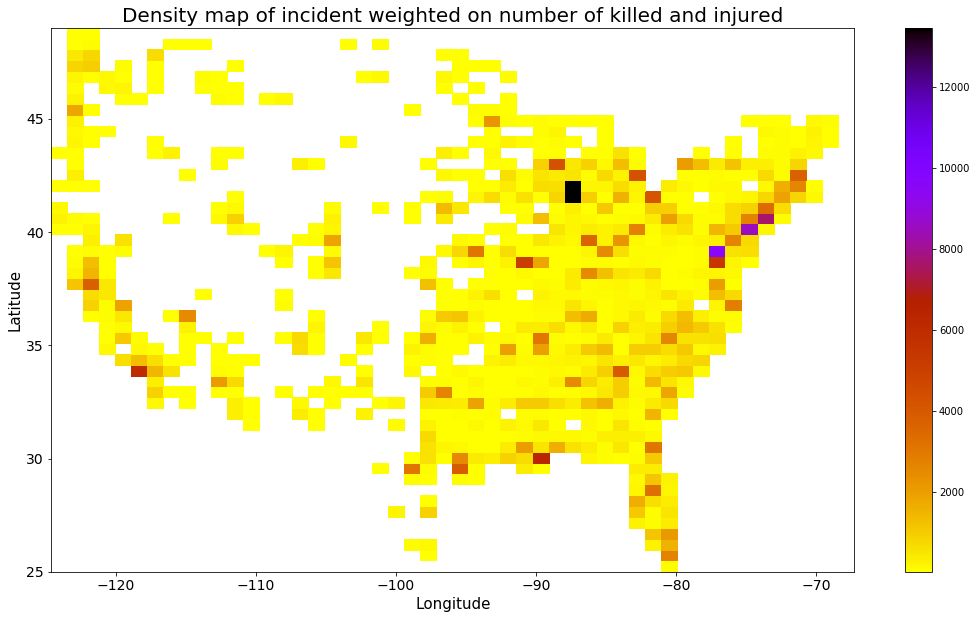

In [78]:
fig = plt.figure(figsize=(18, 10))

temp2 = df.loc[df['longitude'].between(-125, -40) & df['latitude'].between(25, 50), :]
plt.hist2d(temp2['longitude'].dropna(), temp2['latitude'].dropna(), cmin=20,
           weights=temp2['n_victim'].values + 1, 
           bins=50, cmap='gnuplot_r')
plt.colorbar()
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Density map of incident weighted on number of killed and injured', fontsize=20);

### There are spots on a map with very high amount of incident, let's consider city level. Maybe some of them made something to decrease amount of incident.

In [79]:
def city_stats(df, year=None):
    # Make a table with city's statistic each year
    if year:
        df = df.loc[df['year'] == year]
    
    temp = df.reset_index().groupby(by=['city_or_county'])\
    .agg({'n_killed': 'sum', 'n_injured': 'sum', 'n_victim': 'sum', 'incident_id': 'count'})\
    .sort_values(by='n_killed', ascending=False).reset_index().rename(columns={'incident_id': 'count_incidents'})

    temp['avg_killed'] = temp['n_killed'] / temp['count_incidents']
    temp['avg_injured'] = temp['n_injured'] / temp['count_incidents']
    
    temp = temp.loc[:, ['city_or_county', 'avg_killed', 'avg_injured', 'count_incidents']]\
    .sort_values(by='avg_killed', ascending=False)
    
    return temp

In [80]:
for year in range(2014, 2018):
    temp = city_stats(df, year=year).rename(columns={'avg_killed': 'avg_k' + '_' + str(year),
                                                     'avg_injured': 'avg_i' + '_' + str(year),
                                                     'count_incidents': 'count' + '_' + str(year)})
    if year == 2014:
        prev = temp.copy()
        continue
    else:
        prev = prev.merge(temp, on='city_or_county')
        
# remove city with less than 100 incidents
prev = prev.loc[(prev['count_2014'] > 100) | (prev['count_2017'] > 100) ]

# Make table with changes in stats in years. Columns for 2014 is initial rank 
changes = prev.copy()
for stat in ['avg_k', 'avg_i', 'count']:
    for year in range(2015, 2018):
        changes[stat + '_' + str(year)] = changes[stat + '_' + str(year)] - prev[stat + '_' + str(year-1)]
        
changes[['city_or_county'] + [stat + '_' + str(year)
                              for stat in ['avg_k', 'avg_i', 'count']
                              for year in range(2014, 2018)]]\
.sort_values(by='count_2014', ascending=False).head()

,city_or_county,avg_k_2014,avg_k_2015,avg_k_2016,avg_k_2017,avg_i_2014,avg_i_2015,avg_i_2016,avg_i_2017,count_2014,count_2015,count_2016,count_2017
1033,Chicago,0.202742,-0.020310,0.009625,0.011857,0.927032,0.060299,-0.024115,0.007958,2042,326,704,-262
1029,Philadelphia,0.205153,0.144380,-0.009624,0.050797,0.775763,0.031713,-0.066961,0.044338,1048,-513,124,-78
1265,Washington,0.114118,0.120964,-0.027788,-0.116773,0.356471,0.276441,0.033115,-0.369699,850,-297,-32,650
980,Baltimore,0.226316,0.063476,-0.002523,-0.015686,0.581579,0.091308,-0.039590,-0.047865,760,151,8,193
1018,New Orleans,0.215040,0.052653,-0.058755,0.004415,0.568602,0.005245,0.019149,0.106569,758,-108,178,-139


In [81]:
# cities with decreased amount of inciddent in time
good_cities = prev.loc[prev['count_2014'] - prev['count_2017'] >= 0, 
                       ['city_or_county'] + [stat + '_' + str(year) for stat in ['avg_k', 'avg_i', 'count'] 
                                             for year in range(2014, 2018)]]

bad_cities = prev.loc[prev['count_2014'] - prev['count_2017'] < 0, 
                       ['city_or_county'] + [stat + '_' + str(year) for stat in ['avg_k', 'avg_i', 'count'] 
                                             for year in range(2014, 2018)]]

In [82]:
city_coordinates = df.groupby(by='city_or_county')[['longitude', 'latitude']].mean().reset_index()

# Scale circles to show amount changes of incidents
good_cities['weight'] = 100 * np.abs(good_cities['count_2014'] - good_cities['count_2017']) \
/ good_cities['count_2014']
bad_cities['weight'] = 100 * np.abs(bad_cities['count_2014'] - bad_cities['count_2017']) \
/ bad_cities['count_2017']

good_cities = good_cities.merge(city_coordinates, on='city_or_county', how='inner')
bad_cities = bad_cities.merge(city_coordinates, on='city_or_county', how='inner')

In [83]:
colors = ['blue', 'red']
cities = []
names = ['Cities with positive changes', 'Cities with negative changes']

for i, datafrrame in enumerate([good_cities, bad_cities]):
    df_sub = datafrrame
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['longitude'],
        lat = df_sub['latitude'],
        text = df_sub['city_or_county'],
        marker = dict(
            size = df_sub['weight'],
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = names[i])
    cities.append(city)

layout = dict(
        title = 'Cities with more than 100 incidents',
        showlegend = True,
        autosize = True,
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor='rgb(255, 255, 255)',
            countrycolor='rgb(255, 255, 255)'
        ),
    )

fig = dict(data=cities, layout=layout)
pyo.iplot(fig, validate=False)

### There are plenty of example of both city types. But it doesn't seem what any particular state has successful strategy for reduction gun violence.